## Jackson Davis portfolio code demo

This notebook serves as a demonstration of some of the earlier code contained in this repository, which primarily covers various data-processing and machine learning/classification functions.  Except where otherwise noted, all code is written by myself in Python 3.9-3.10.  For more information on any of the functions used, please see the documentation in the source code.

For more information on myself or for contact, see https://www.sevenhillsmt.com/jackson-portfolio

In [1]:
import davis_ml_lib as dml
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sns

## Preprocessing

First, we import the necessary libraries and load and pre-process the data.  For this demo I'm using both the Iris and MNIST datasets.  

The Iris dataset is a small dataset of 150 samples, each with 4 features and 3 classes.  

The MNIST dataset is a much larger dataset of 70,000 samples, each with 784 features (28x28 pixels) and 10 classes (digits 0-9). The MNIST dataset is a classic dataset used for image classification, and is a good example to use for demonstrating preprocessing as well as classification.

In [2]:
iris_data = pd.read_csv('iris.csv')

print(iris_data.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


The Iris dataset requires very little processing; after loading it up we simply split it into training and testing sets as numpy arrays.

In [3]:
iris_x = iris_data.loc[:,iris_data.columns != 'species'].to_numpy()
iris_y = iris_data['species'].to_numpy()

As a quick demonstration, we run a Principal Component Analysis (PCA) on the Iris dataset and plot the first two principal components, which account for most of the variance in the dataset.  We can see that the three classes are well-separated in the first two principal components, which is one reason why the Iris dataset is often used as a demonstration of classification algorithms.  The PCA-generated features are not used in the classification algorithms below (because the plots look nicer with the original features); PCA is done here simply as a demonstration.

Explained variance ratio: [0.92461621 0.05301557 0.01718514] Total explained: 99.48%
Explained variance: [4.22484077 0.24224357 0.07852391]


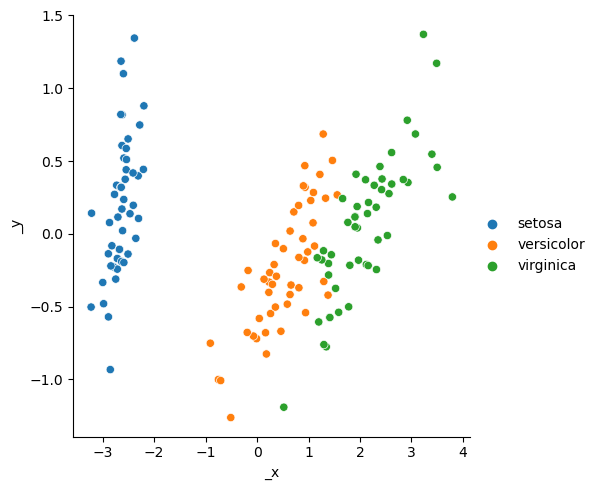

In [4]:
pca_data = dml.preprocessing.pca_n(data=iris_x, y=iris_y, n_components=3, verbose=True)

The MNIST dataset, on the other hand, requires a bit more processing.  After loading it up, we first split it into observations and class labels, and reorganize each image into a 28x28 matrix rather than a flat vector.

In [5]:
m_data = pd.read_csv('mnist.csv')
m_data_y = m_data.pop('label').to_numpy()
m_data_x = m_data.to_numpy().reshape(-1,28,28)
print(m_data_x.shape)

(42000, 28, 28)


The next step is to reduce the dimensionality of the dataset.  The MNIST dataset has 784 features, each representing individual pixels, which is a lot for a classification algorithm to handle effectively.  We can reduce the dimensionality of the dataset by using a variety of techniques, and the ones used below end up with an effect similar to the PCA above.  

First, we will be using a Discrete Cosine Transform (DCT) to generate numerical features from the pixel data, and using the mask matrices below we will extract the diagonal, vertical, and horizontal components of the DCT to work on them separately.

In [6]:
# Mask matrices to extract diagonal, vertical, and horizontal components of 
# a DCT matrix.  Used in the DCT-based feature generation method below.

DIAG_MASK=np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
                   [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
                  ])

VERT_MASK =np.array([[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                  ])

HORIZ_MASK = np.array([[ 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

MASKS = [DIAG_MASK, VERT_MASK, HORIZ_MASK]


In [7]:
m_data_x_dct = np.array([dml.preprocessing.mnist_dct(image, dml.preprocessing.MASKS) for image in m_data_x])
print(m_data_x_dct.shape)

(42000, 3)


After running the DCT function, each observation, which was originally a 28x28 pixel image, is now a 28x28 matrix of DCT coefficients, flattened into three separate vectors representing the diagonal, vertical, and horizontal components of the DCT.  The total number of features is still 784, but now each feature is a DCT coefficient rather than a pixel value.

In [8]:
for i in m_data_x_dct[0]:
    print(i.shape)

(335,)
(224,)
(224,)


The next processing step is an eigendecomposition, which is similar to the PCA above.  The eigendecomposition is done on the covariance matrix of the dataset, which is a 784x784 matrix.  The eigendecomposition returns the eigenvectors and eigenvalues of the covariance matrix, which are used to transform the dataset into a new set of features.  

The new features are the eigenvectors of the covariance matrix, represent how much variance each eigenvector accounts for.  The eigenvectors are sorted by the amount of variance they account for, and the first 20 eigenvectors of each component are used as the new features.  This reduces the total number of features from 784 to 60 with little information loss.

In [9]:
output_1 = dml.preprocessing.mnist_eigendecomp(m_data_x_dct)
print(output_1.shape)

(42000, 60)


The above functions were called for demonstration, but the full processing pipeline is contained in the `mnist_preprocess` function, which takes in the raw MNIST data and returns the processed data, as well as a processing "model", which can be used to process incoming data in the same way to classify new observations without redoing all of the processing.

In [10]:
m_data_x_preproc, preproc_model = dml.preprocessing.mnist_preprocess(m_data_x, reuse=True)
print(m_data_x_preproc.shape)

# Processes the first image in the raw data set using parameters from the preproc_model.  
m_data_single = dml.preprocessing.mnist_preprocess(m_data_x[0], preproc_model=preproc_model)
print(m_data_single.shape)

(42000, 60)
(1, 60)


In [11]:
# Result using the model is the same as the first image in m_data_x_preproc.
print(np.isclose(m_data_single, m_data_x_preproc[0]).all())

True


## Feature selection

Now that we have our pre-processed data, we will need to further reduce the feature space.  Since the classifiers used below will be plotting data on 2D plots, we will only be able to use two features at a time. For the Iris dataset, a simple custom feature-ranking function suffices.  This rather simple legacy function is included here partly for nostalgia; I have learned much better practices since writing it.  However, it works well enough.

In [12]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_df = pd.DataFrame(iris_x, columns=features)
iris_df['species'] = iris_y

dml.preprocessing.feature_rank(iris_df, features, category_column='species')

,accuracy
"['sepal_length', 'petal_length', 'petal_width']",0.986667
"['sepal_length', 'sepal_width', 'petal_length', 'petal_width']",0.98
"['petal_length', 'petal_width']",0.973333
"['sepal_length', 'petal_width']",0.966667
"['sepal_width', 'petal_length', 'petal_width']",0.966667
['petal_width'],0.96
"['sepal_length', 'petal_length']",0.96
"['sepal_width', 'petal_length']",0.96
"['sepal_length', 'sepal_width', 'petal_length']",0.96
['petal_length'],0.953333


As we can see, the 'petal length' and 'petal width' features are the most important two features for classifying the dataset, so we will be using those for the plotting algorithms below, first standardizing to mean = 0 and Standard Deviation = 1 for compatibility with various classifiers.

In [13]:
iris_plot_x = iris_x[:,2:4]
iris_plot_x = dml.preprocessing.standardize(iris_plot_x)
iris_plot_y = iris_y
print(iris_plot_x.shape)

(150, 2)


The MNIST dataset is rather more complicated, and for this we will use the Fisher's Discriminant Ratio to rank the features.  First we divide the dataset by class:

In [14]:
mnist_classes = np.unique(m_data_y)
class_indices = {i:list(np.where(m_data_y == i)[0]) for i in mnist_classes}
for i in mnist_classes:
    print(i,':', len(class_indices[i]))

0 : 4132
1 : 4684
2 : 4177
3 : 4351
4 : 4072
5 : 3795
6 : 4137
7 : 4401
8 : 4063
9 : 4188


Then we get a 2D Fisher's Discriminant Ratio matrix showing how well each feature separates each pair of classes.  The resulting matrix is large, but a simple heatmap can visualize roughly where the most important features are, with brighter rows indicating better separation.

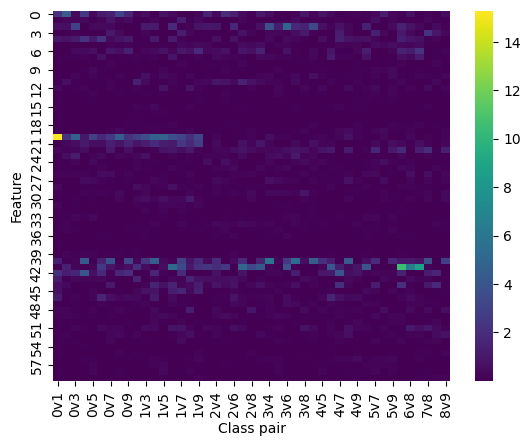

In [15]:
fdr_matrix = dml.preprocessing.get_2Dfdr_matrix(pd.DataFrame(m_data_x_preproc),class_indices)
ax = sns.heatmap(fdr_matrix.T, cmap='viridis')
ax.set(xlabel='Class pair', ylabel='Feature')
pass

As we can see from some quick analysis below, the features closest to 0, 20, and 40 provide the best separability, which makes sense given our preprocessing steps above.

In [16]:
analysis = pd.DataFrame(columns=fdr_matrix.columns)
analysis.loc['Best separation'] = fdr_matrix.max()
analysis.loc['Most separated pair'] = fdr_matrix.idxmax()
analysis.loc['Overall separation'] = (fdr_matrix.mean() * fdr_matrix.median())

analysis = analysis.sort_values('Overall separation', axis=1, ascending=False)
top_ten = list(analysis.columns[:10])

print("Top ten features:", top_ten)
display(analysis.transpose().head())

Top ten features: [40, 41, 2, 20, 0, 21, 22, 4, 42, 6]


,Best separation,Most separated pair,Overall separation
40,5.796107,3v4,1.888391
41,10.443484,6v7,1.021318
2,4.852698,3v6,0.360891
20,15.273306,0v1,0.318786
0,4.32305,0v2,0.269229


For the sake of pretty plots and simplicity, I have chosen to drastically reduce the size of the dataset, and to use features 40 and 41 from the above analysis.  I also standardize the data to have a mean of 0 and a standard deviation of 1 for use in a variety of classification algorithms.

In [17]:
mnist_plot_x = m_data_x_preproc[:1000]
mnist_plot_y = m_data_y[:1000]

mnist_plot_x = dml.preprocessing.standardize(mnist_plot_x[np.where(np.isin(mnist_plot_y, [3,4,6]))])
mnist_plot_y = mnist_plot_y[np.where(np.isin(mnist_plot_y, [3,4,6]))]
mnist_plot_x = mnist_plot_x[:,40:42]
print(mnist_plot_x.shape)

(289, 2)


## Classification

Now that we have some processed data, we're ready to try a few classifiers.  There are more classifiers available in other sections of the portfolio repository, but for this demo I will be using a few of the most common ones.  First, we'll use a simple Bayes Classifier that assumes a Gaussian distribution for each class to demonstrate some of the helper functions.

First, we'll run a quick K-fold test on the entire MNIST dataset to get an idea of how well the classifier performs.  We won't do this for all of the classifiers, but it's good to know how.  This K-fold test uses simple accuracy as a metric, but other metrics are available in other sections of the repository.

In [18]:
dml.helpers.K_fold_test(m_data_x_preproc, m_data_y, 10, classifier='BAYES', verbose=True)
pass

Accuracy for test #1, BAYES classifier: 88.43%
Accuracy for test #2, BAYES classifier: 88.19%
Accuracy for test #3, BAYES classifier: 88.07%
Accuracy for test #4, BAYES classifier: 88.24%
Accuracy for test #5, BAYES classifier: 89.02%
Accuracy for test #6, BAYES classifier: 88.00%
Accuracy for test #7, BAYES classifier: 88.14%
Accuracy for test #8, BAYES classifier: 88.50%
Accuracy for test #9, BAYES classifier: 89.36%
Accuracy for test #10, BAYES classifier: 87.93%
Average accuracy for 10-fold cross validation, BAYES classifier with rbf kernel, C = 3.0, arg(sigma/D)=0.15: 88.39%


Not too bad for such a simple classifier, but certainly nothing to write home about.  Now let's try it on the Iris dataset:

In [19]:
dml.helpers.K_fold_test(iris_x, iris_y, 5, classifier='BAYES', verbose=True)
pass

Accuracy for test #1, BAYES classifier: 90.00%
Accuracy for test #2, BAYES classifier: 96.67%
Accuracy for test #3, BAYES classifier: 83.33%
Accuracy for test #4, BAYES classifier: 93.33%
Accuracy for test #5, BAYES classifier: 86.67%
Average accuracy for 5-fold cross validation, BAYES classifier with rbf kernel, C = 3.0, arg(sigma/D)=0.15: 90.00%


Many of the other classifiers will outperform the simple Bayes, but it's a good baseline to start with.

Next we'll just be running a few classifiers through some simple plots to see what the decision boundaries look like, and that will conclude our tour!

## Parzen Window

First is a Parzen Window classifier.  This classifier is a non-parametric classifier, meaning that it does not assume any particular distribution for the data.  It works by placing a window around each observation and counting the number of observations in each class within the window.  The class with the most observations in the window is the class assigned to the observation.  The size of the window is a hyperparameter that can be tuned to improve performance, and the shape of the window can be changed as well.  The window shape used here is a simple Gaussian kernel.  Plots with different 'h' values are shown below to demonstrate the effect of the window size.

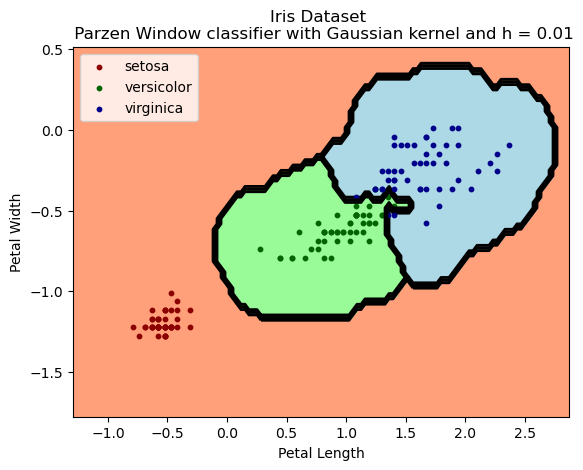

In [20]:
h = 0.01
plot_info = {'title': f"Iris Dataset \n Parzen Window classifier with Gaussian kernel and h = {h}", 'xlabel': "Petal Length", 'ylabel': "Petal Width"}
classifier = partial(dml.classifiers.parzen_kernel_classifier, h=h)
dml.helpers.decision_boundary_plot(iris_plot_x, iris_plot_y, classifier, plot_info)

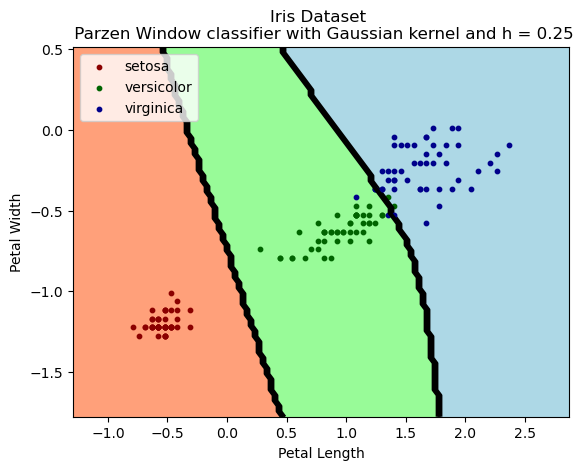

In [21]:
h = 0.25
plot_info = {'title': f"Iris Dataset \n Parzen Window classifier with Gaussian kernel and h = {h}", 'xlabel': "Petal Length", 'ylabel': "Petal Width"}
classifier = partial(dml.classifiers.parzen_kernel_classifier, h=h)
dml.helpers.decision_boundary_plot(iris_plot_x, iris_plot_y, classifier, plot_info)

And with the MNIST dataset:

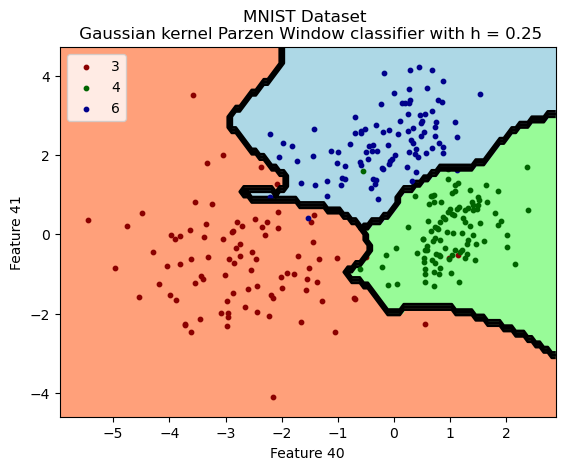

In [22]:
h = 0.25
classifier = partial(dml.classifiers.parzen_kernel_classifier, h=h)
plot_info = {'title': f"MNIST Dataset \n Gaussian kernel Parzen Window classifier with h = {h}", 'xlabel': "Feature 40", 'ylabel': "Feature 41"}
dml.helpers.decision_boundary_plot(mnist_plot_x, mnist_plot_y, classifier, plot_info)

## Radial Basis Function Neural Network

Next is a Radial Basis Function Neural Network.  This is a simple 'neural network' that uses a Gaussian activation function and functions somewhat differently than the classic NN with fully connected hidden layers.  The 'spread' parameter is a hyperparameter that tunes the size of the Gaussian activation function.

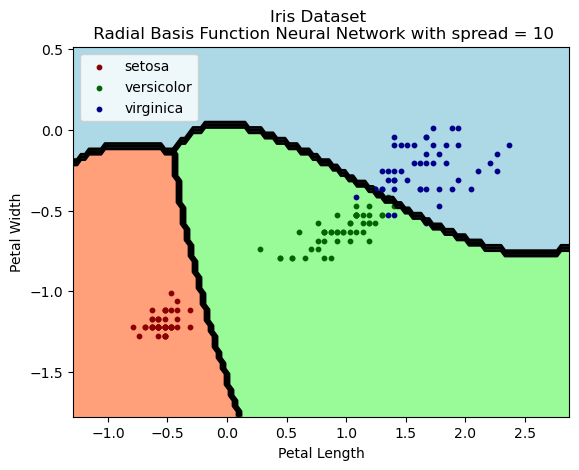

In [23]:
spread = 10
plot_info = {'title': f"Iris Dataset \n Radial Basis Function Neural Network with spread = {spread}", 'xlabel': "Petal Length", 'ylabel': "Petal Width"}
classifier = partial(dml.helpers.one_v_all_classify_pipeline, classifier='RBFNN', arg=spread)
dml.helpers.decision_boundary_plot(iris_plot_x, iris_plot_y, classifier, plot_info)

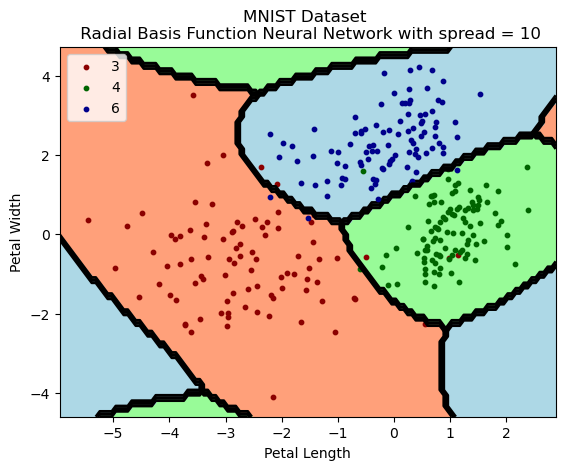

In [24]:
spread = 10
plot_info = {'title': f"MNIST Dataset \n Radial Basis Function Neural Network with spread = {spread}", 'xlabel': "Petal Length", 'ylabel': "Petal Width"}
classifier = partial(dml.helpers.one_v_all_classify_pipeline, classifier='RBFNN', arg=spread)
dml.helpers.decision_boundary_plot(mnist_plot_x, mnist_plot_y, classifier, plot_info)

## Support Vector Machine

Finally we have a Support Vector Machine.  This is a classic classifier that works by finding the hyperplane that best separates the classes.  The 'C' parameter is a hyperparameter that tunes the penalty for misclassifying an observation, and the 'h' parameter here is a hyperparameter that tunes the size of the Gaussian kernel used to separate the classes.  The 'kernel' parameter can be used to change the kernel used to separate the classes, but the Gaussian kernel is used here.

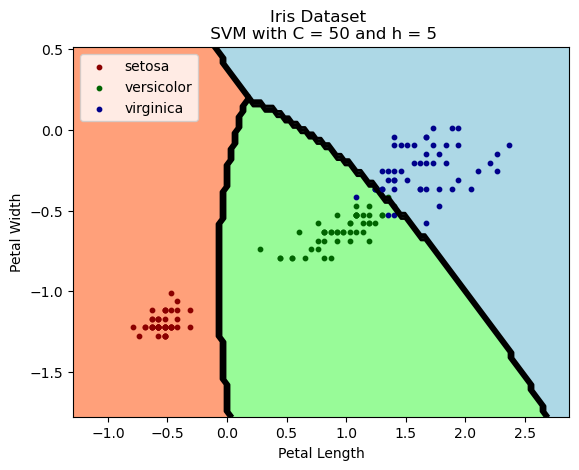

In [25]:
C = 50
h = 5
plot_info = {'title': f"Iris Dataset \n SVM with C = {C} and h = {h}", 'xlabel': "Petal Length", 'ylabel': "Petal Width"}
classifier = partial(dml.helpers.one_v_all_classify_pipeline, classifier='SVM', C=C, arg=h)
dml.helpers.decision_boundary_plot(iris_plot_x, iris_plot_y, classifier, plot_info)

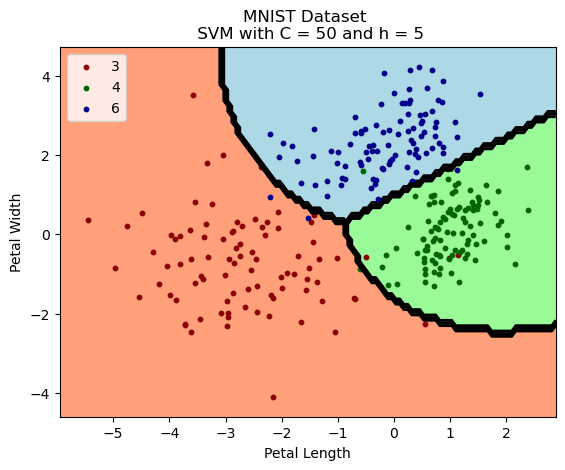

In [26]:
C = 50
h = 5
plot_info = {'title': f"MNIST Dataset \n SVM with C = {C} and h = {h}", 'xlabel': "Petal Length", 'ylabel': "Petal Width"}
classifier = partial(dml.helpers.one_v_all_classify_pipeline, classifier='SVM', C=C, arg=h)
dml.helpers.decision_boundary_plot(mnist_plot_x, mnist_plot_y, classifier, plot_info)

Many of these are some of my earliest attempts at writing machine learning algorithms, and I have learned much since then, but I hope you enjoyed this tour of some of my code!  Check out some of the other notebooks for more examples of my work.